In [2]:
import warnings
warnings.filterwarnings('ignore')

# necessary packages
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

# additional certain short functions
from torch import is_tensor
from matplotlib.pyplot import pause
from random import randint
from copy import deepcopy
from math import floor, ceil
from torch import stack
from torch import cat

ground truth =  Coat
Dataset size =  60000


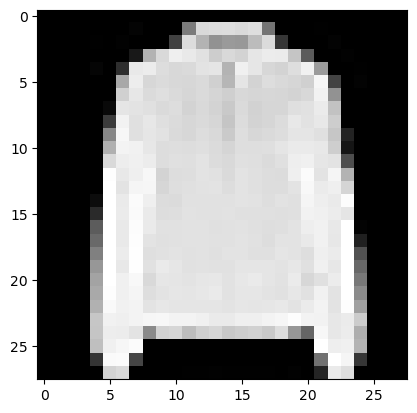

In [3]:
# get training dataset
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# get testing dataset
testing_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# class names
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# print random item to visualize
rand = random.randint(0, 59999)
img = training_data.data[rand]
plt.imshow(img, cmap='gray')
print("ground truth = ", training_data.classes[training_data.targets[rand]])

# print dataset size 
size = len(training_data)
print("Dataset size = ", size)

In [40]:
# object picking
def pick(dataset: datasets, name: list, number: int) -> list:
    i = 0
    counter = [0] * len(name)
    score = []
    while True:
        if dataset.classes[dataset.targets[i]] in name and \
            counter[name.index(dataset.classes[dataset.targets[i]])] < number:
                if score == []:
                    score = dataset.data[i].reshape(1, 28, 28)
                else:
                    score = cat((score, dataset.data[i].reshape(1, 28, 28)), dim=0)
                counter[name.index(dataset.classes[dataset.targets[i]])] += 1
        i += 1
        correct = 0
        for j in range(len(name)):
            if counter[j] == number:
                correct += 1
        if correct == len(name):
            return score
        
# sequential album extension
def album(dataset: datasets, is_rand_stride: bool, is_rand_pos: bool) -> torch.Tensor:
    expansion = []      # list after expanded
    temp = []           # list after every step
    stride = 5          # default stride
    pos = [14, 27]      # default starting position [col, row]
    num_list = [0] * len(dataset)       # record number for each original album
    score_list = [0] * len(dataset)     # record number for each final album
    stride_list = [0] * len(dataset)    # record stride for each final album
    
    # expand and clean
    for i in range(len(dataset)):
        if i == 0:
            expansion = dataset[i].repeat(3, 4).reshape(1, 28*3, 28*4)
        else:
            buffer = dataset[i].repeat(3, 4).reshape(1, 28*3, 28*4)
            expansion = cat((expansion, buffer), dim=0)
        expansion[i][:, 28:] = 0
        expansion[i][28:, :] = 0
    expansion = torch.tensor(expansion, dtype=torch.float32)
    print("expansion shape =", expansion.shape)
    
    # random stride
    for i in range(len(num_list)):
        # define stride value
        if is_rand_stride == True: stride = randint(3, 7)
        # album generation
        first_frame = deepcopy(expansion[i])
        next_frame = deepcopy(expansion[i])
        y = deepcopy(expansion[i])
        for j in range(floor((112-28)/stride)):
            # moving part (1-dim only)
            for z in range(28):
                next_frame[:, 28+stride*(j+1)-(z+1)] = next_frame[:, 28+stride*j-(z+1)]
            # clean other area
            next_frame[:, :stride*(j+1)+1] = 0
            # sequencing part
            if j == 0: y = stack((first_frame, next_frame)) 
            else: y = cat((y, next_frame.reshape(1, 28*3, 28*4)), dim=0)
        # record number
        num_list[i] = len(y)
        # sequencing part
        if i == 0: temp = y
        else: temp = cat((temp, y), dim=0)
        # renew stride_list
        stride_list[i] = stride

    # random position
    if is_rand_pos == True: 
        for i in range(len(num_list)):
            # define position value
            pos = [randint(14, 27), randint(27, 28*3-1)]    # [col, row]
            stride = floor((112-28)/(num_list[i]-1))        # re-inference stride value
            # parallel movement
            for j in range(num_list[i]):
                for k in range(28):
                    for l in range(28):
                        temp[sum(num_list[:i])+j][pos[1]-k][pos[0]+stride*j-l] = \
                            temp[sum(num_list[:i])+j][27-k][27+stride*j-l]
                # clean other area
                temp[sum(num_list[:i])+j][:pos[1]-28+1, :] = 0
                temp[sum(num_list[:i])+j][:, pos[0]+stride*j+1:] = 0
            # fill temp into score
            if i == 0: score = temp[:num_list[i]]
            else: score = cat((score, temp[sum(num_list[:i]):sum(num_list[:i+1])]), dim=0)
            # fetch up last frames
            next_frame = deepcopy(temp[sum(num_list[:(i+1)])-1])
            for j in range(ceil((28-pos[0])/stride)+1):
                for k in range(28):
                    if pos[0]+stride*(num_list[i]+j)-k < 112:
                        next_frame[:, pos[0]+stride*(num_list[i]+j)-k] = \
                            next_frame[:, pos[0]+stride*(num_list[i]+j-1)-k]
                # clean other area
                next_frame[:, :pos[0]+stride*(num_list[i]+j)-28+1] = 0
                score = cat((score, next_frame.reshape(1, 28*3, 28*4)), dim=0)
            # renew score_list
            score_list[i] = num_list[i]+j+1
    
    # print list shape
    print("temp shape =", temp.shape)
    print("numbers of each original album =", num_list)

           
    if is_rand_pos == True:
        print("score shape =", score.shape)
        print("numbers of each final album =", score_list)

    # return setting (add stride_list afterward)
    if is_rand_pos == True:
        return score, score_list, stride_list
    else:
        return temp, num_list, stride_list
    
# frame differences generation function
def dif_frame(dataset: datasets, num_list: list) -> torch.Tensor:
    score = []                          # return tensor
    node = [0] * len(num_list)          # node for swithing album
    front_frame = deepcopy(dataset[0])
    back_frame = deepcopy(dataset[1])
    # sum the num for node list
    for i in range(len(num_list)):
        node[i] = sum(num_list[:i])
    print(node)
    for i in range(len(dataset)):
        # reset front_frame and back_frame when switching album
        if i in node:
            front_frame = dataset[i]
            back_frame = dataset[i+1]
            continue
        if i == 1: score = abs(back_frame - front_frame).reshape(1, 28*3, 28*4)
        else: score = cat((score, abs(back_frame - front_frame).reshape(1, 28*3, 28*4)), dim=0)
        # renew front_frame and back_frame within one album 
        if i < len(dataset)-1:
            front_frame = back_frame
            back_frame = dataset[i+1]
        # print the result
        print(score.shape)
    return score
            
# vector generation function
def vector(num_list: list, stride_list: list) -> torch.Tensor:
    # TO BE DONE!!
    pass


In [43]:
dataset = training_data
name = [
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
number = 1

test = pick(dataset, name, number)
test, number_list, stride_list = album(test, is_rand_stride = True, is_rand_pos = True)
print("length of number_lsit =", len(number_list))
print("sum of first 2 elements in number_list =", sum(number_list[:2]))
print("stride_list =", stride_list)

expansion shape = torch.Size([4, 84, 112])
temp shape = torch.Size([62, 84, 112])
numbers of each original album = [15, 13, 17, 17]
score shape = torch.Size([72, 84, 112])
numbers of each final album = [17, 16, 20, 19]
length of number_lsit = 4
sum of first 2 elements in number_list = 33
stride_list = [6, 7, 5, 5]


In [44]:
test = dif_frame(test, number_list)

[0, 17, 33, 53]
torch.Size([1, 84, 112])
torch.Size([2, 84, 112])
torch.Size([3, 84, 112])
torch.Size([4, 84, 112])
torch.Size([5, 84, 112])
torch.Size([6, 84, 112])
torch.Size([7, 84, 112])
torch.Size([8, 84, 112])
torch.Size([9, 84, 112])
torch.Size([10, 84, 112])
torch.Size([11, 84, 112])
torch.Size([12, 84, 112])
torch.Size([13, 84, 112])
torch.Size([14, 84, 112])
torch.Size([15, 84, 112])
torch.Size([16, 84, 112])
torch.Size([17, 84, 112])
torch.Size([18, 84, 112])
torch.Size([19, 84, 112])
torch.Size([20, 84, 112])
torch.Size([21, 84, 112])
torch.Size([22, 84, 112])
torch.Size([23, 84, 112])
torch.Size([24, 84, 112])
torch.Size([25, 84, 112])
torch.Size([26, 84, 112])
torch.Size([27, 84, 112])
torch.Size([28, 84, 112])
torch.Size([29, 84, 112])
torch.Size([30, 84, 112])
torch.Size([31, 84, 112])
torch.Size([32, 84, 112])
torch.Size([33, 84, 112])
torch.Size([34, 84, 112])
torch.Size([35, 84, 112])
torch.Size([36, 84, 112])
torch.Size([37, 84, 112])
torch.Size([38, 84, 112])
torch

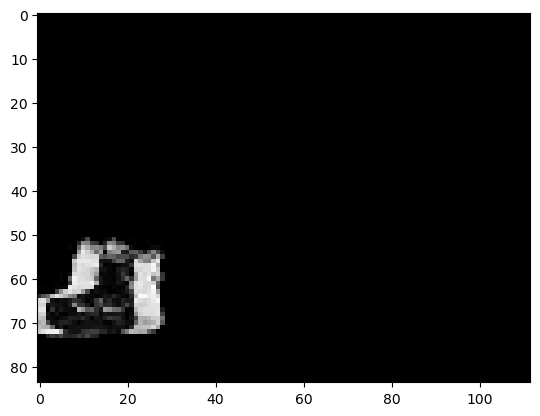

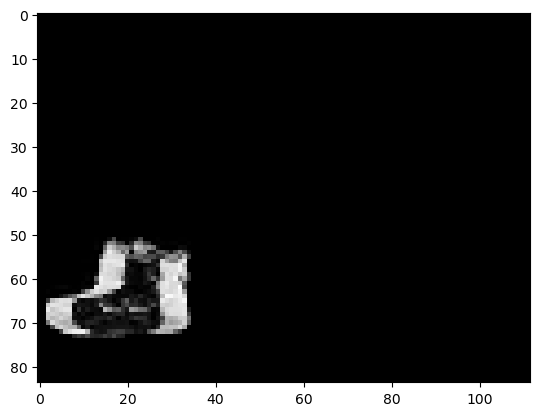

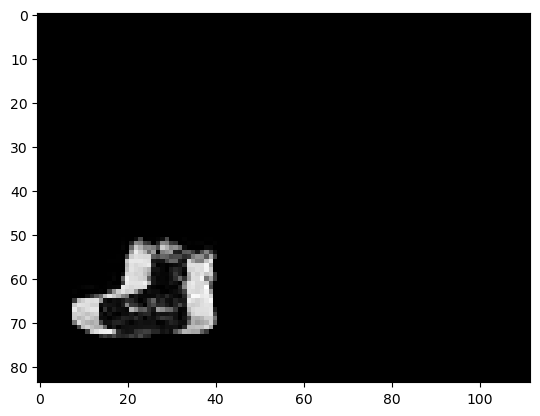

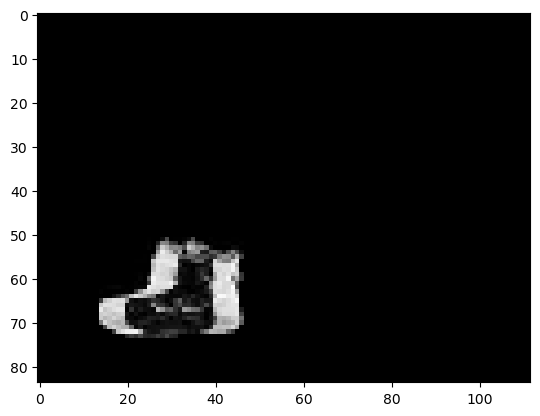

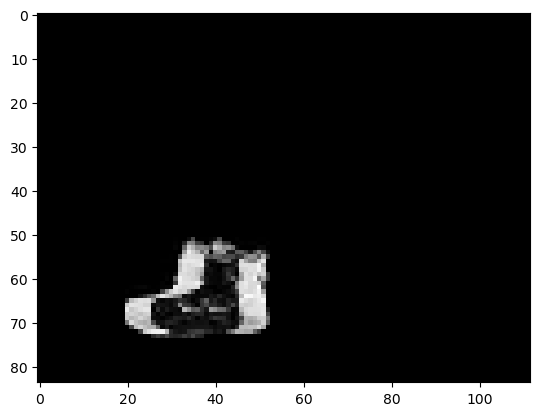

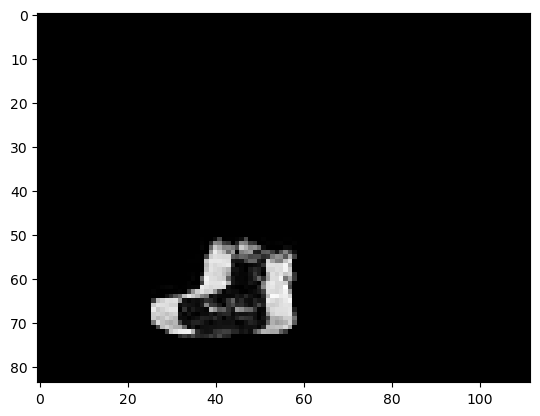

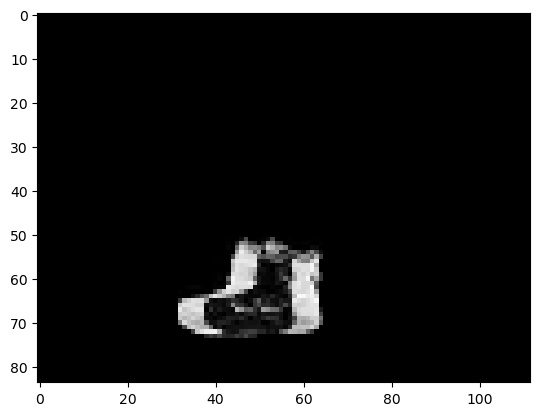

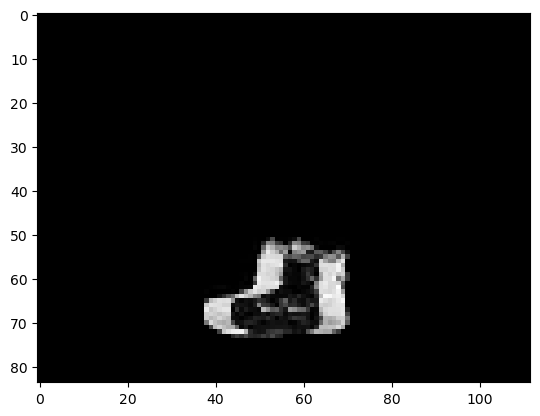

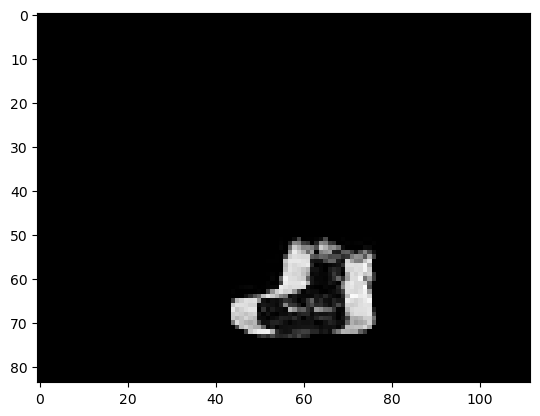

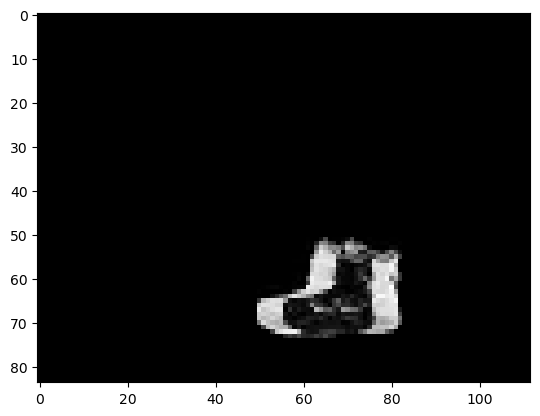

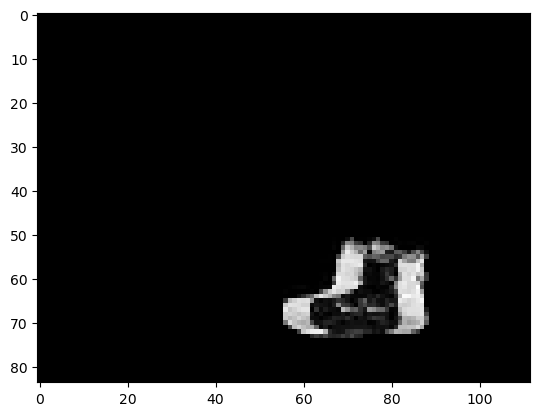

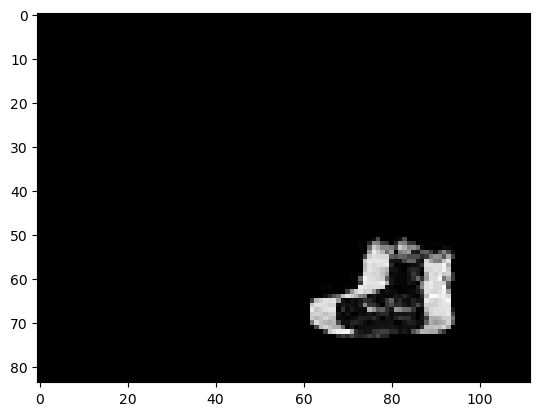

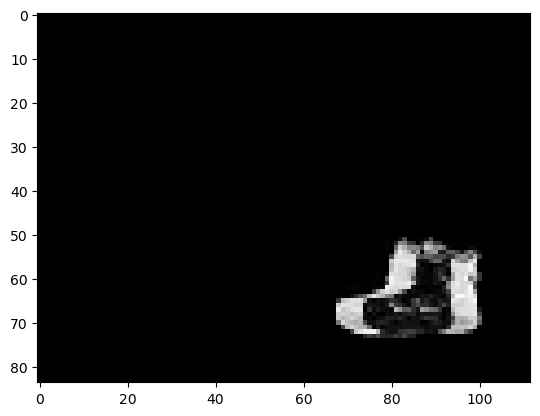

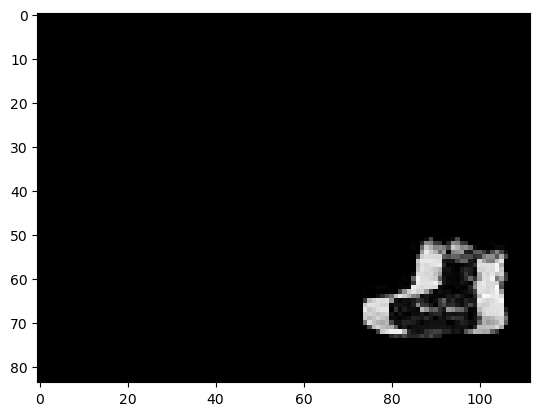

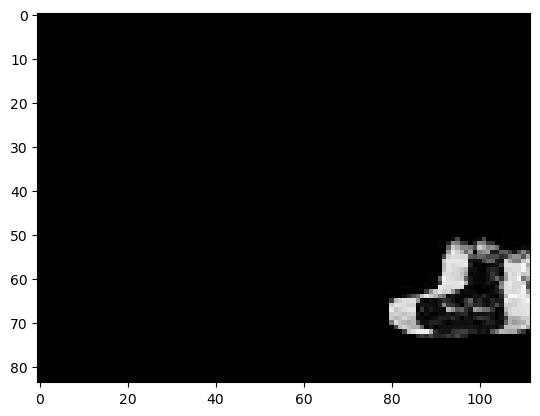

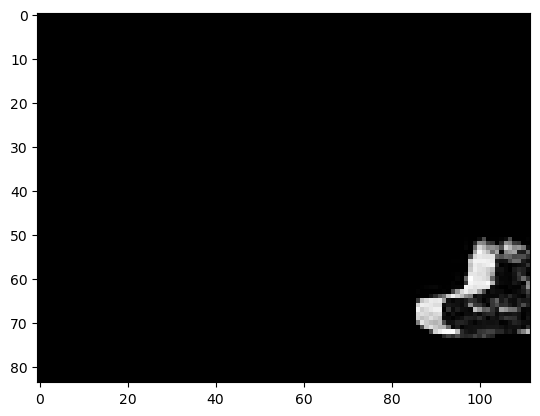

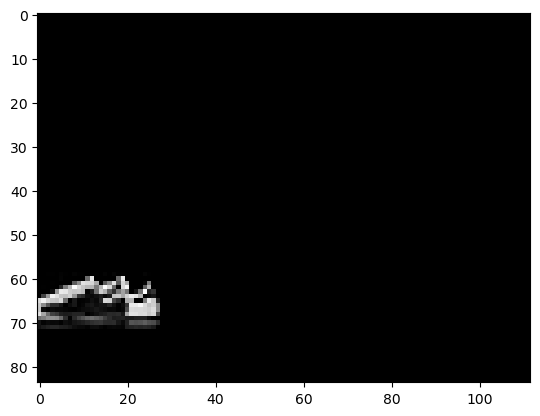

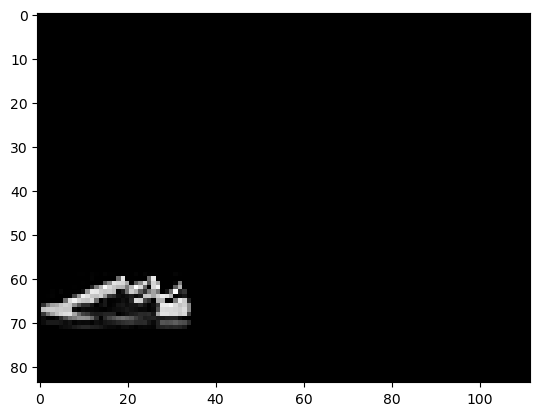

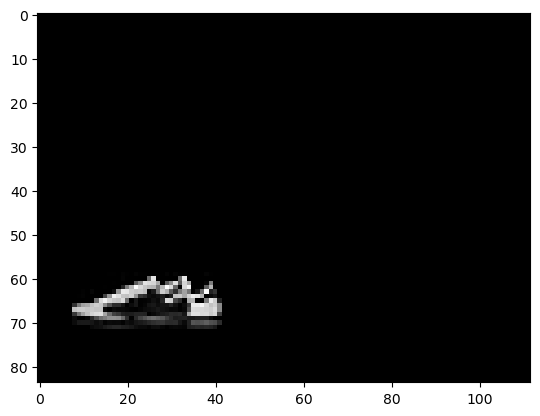

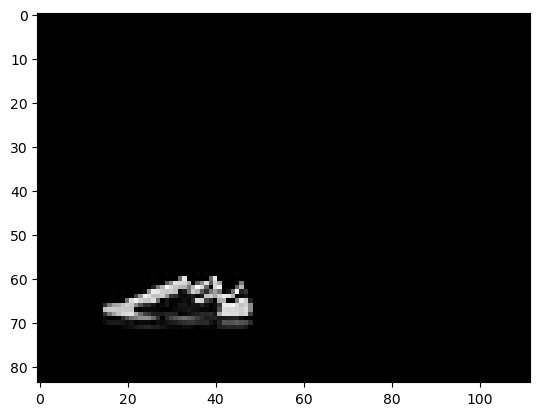

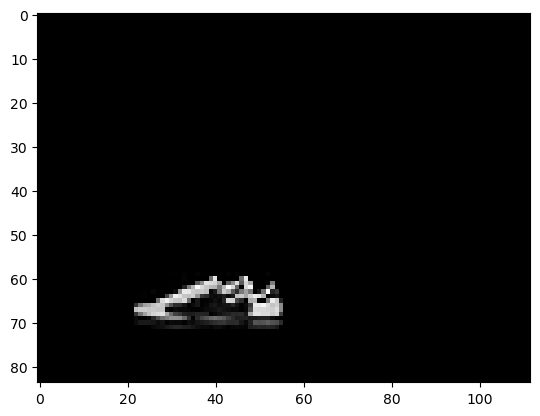

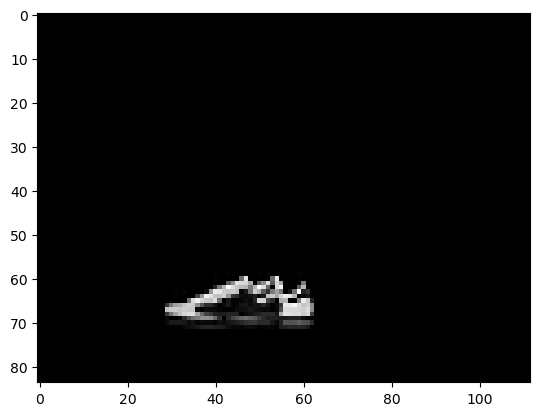

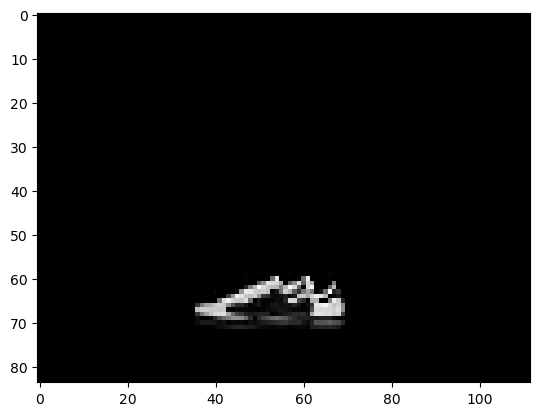

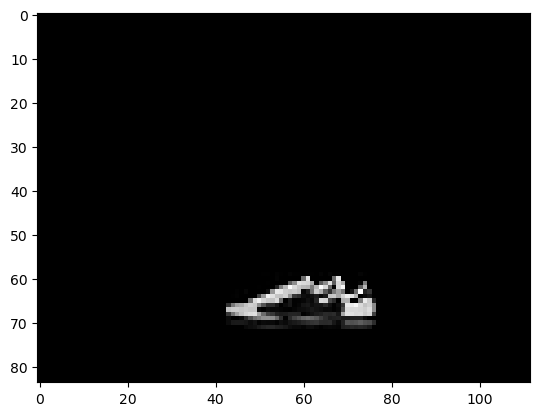

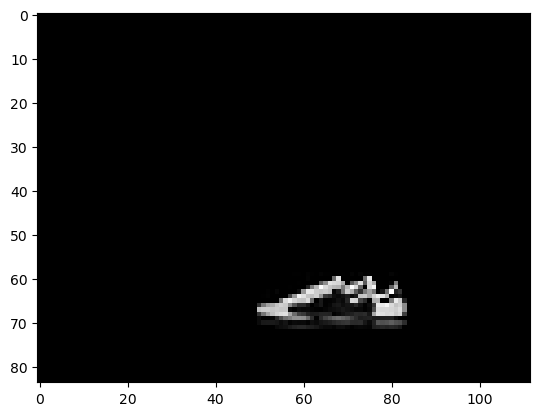

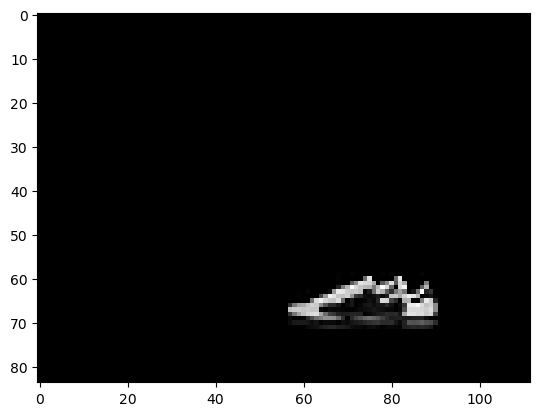

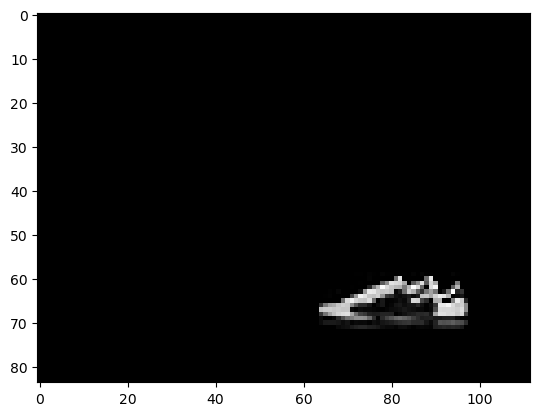

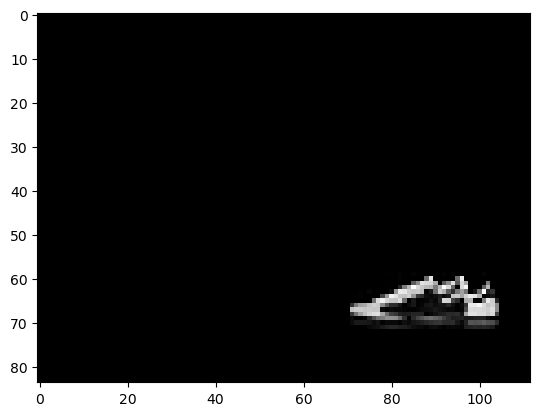

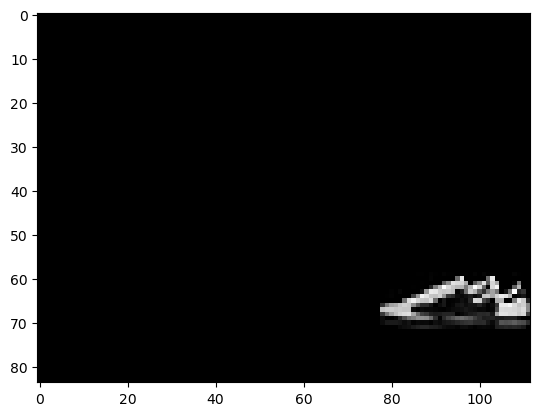

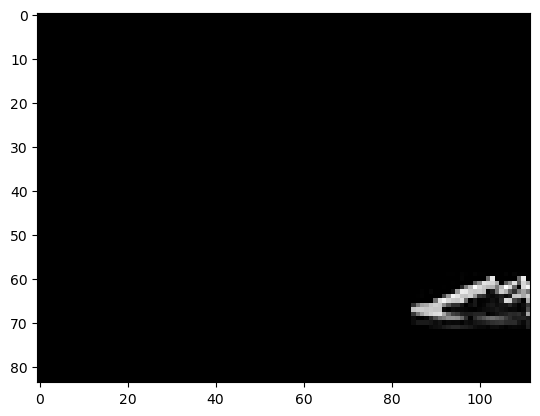

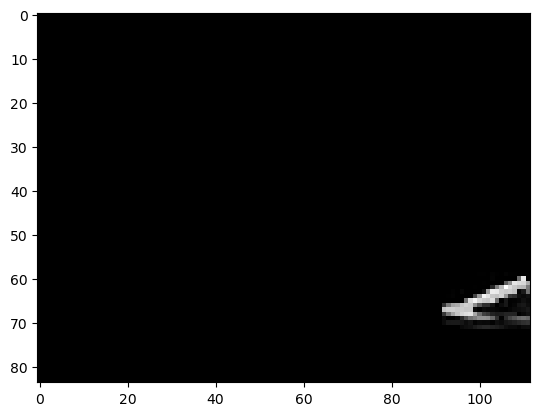

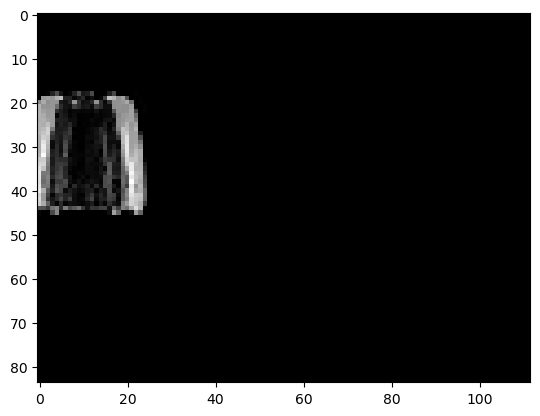

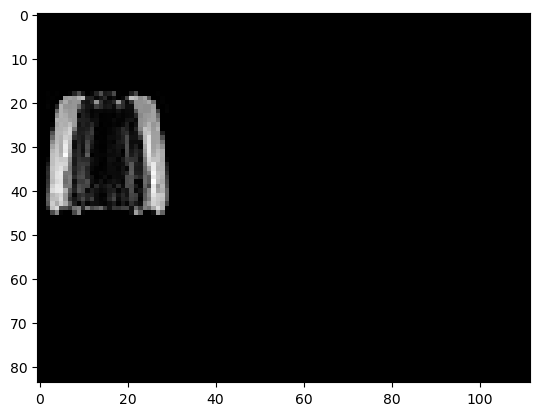

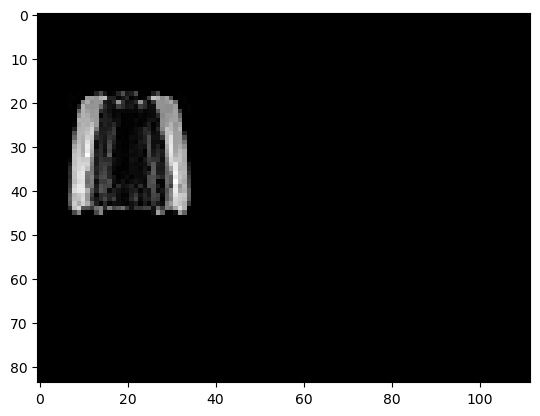

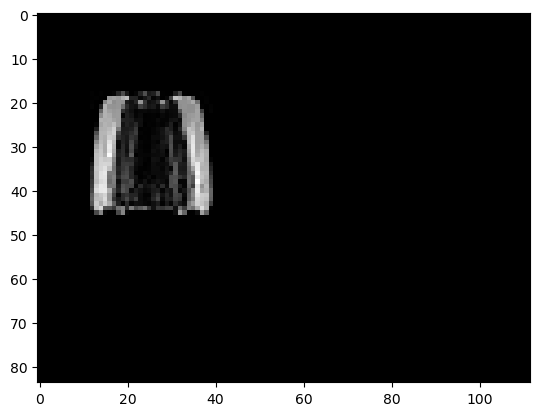

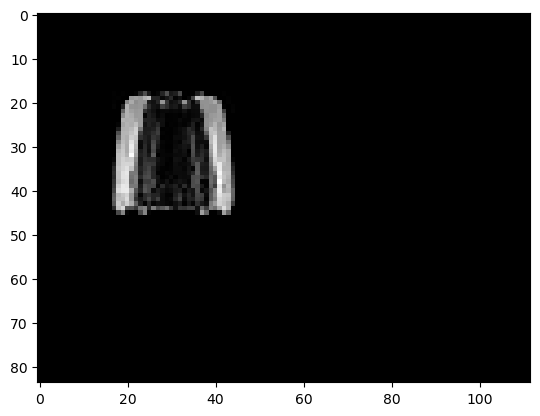

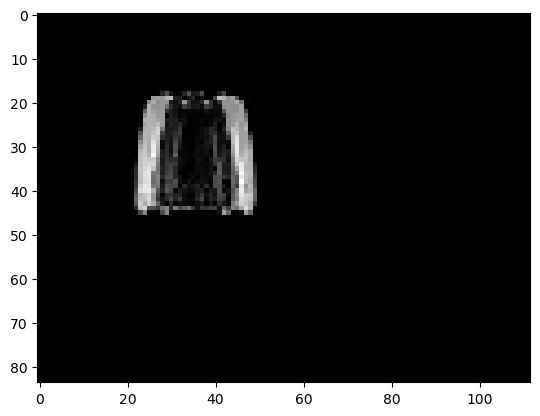

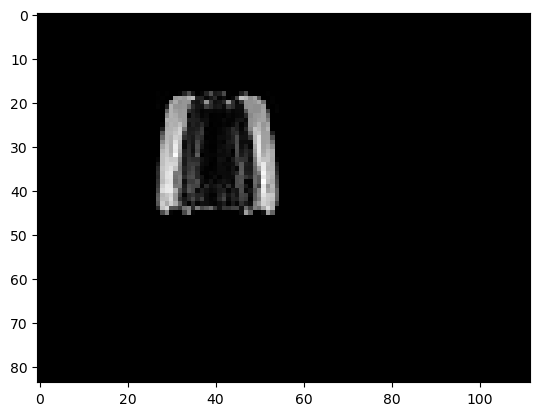

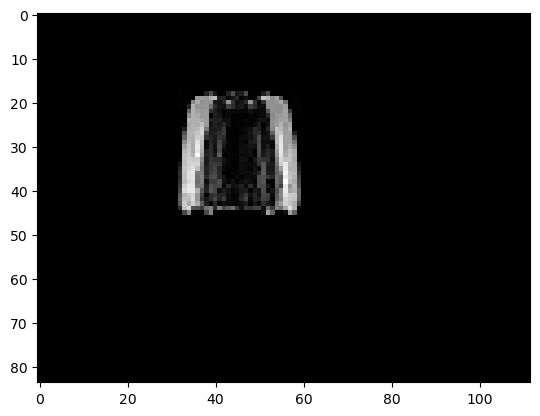

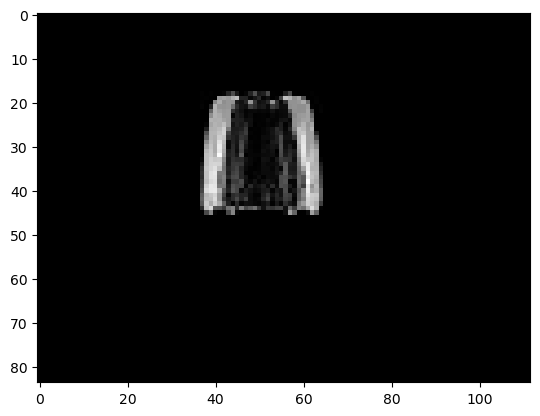

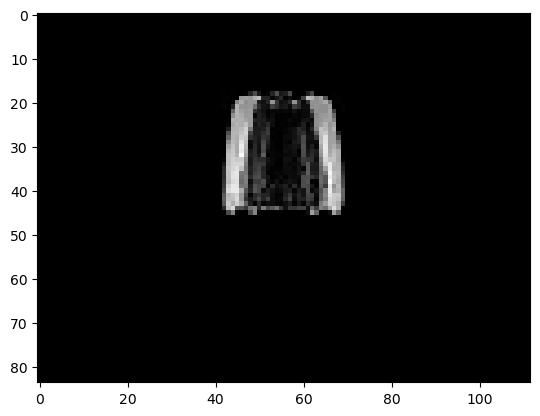

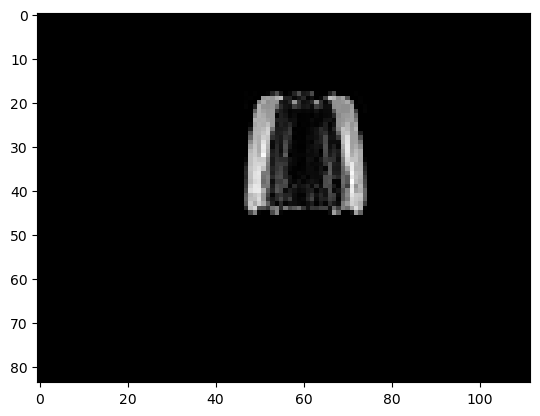

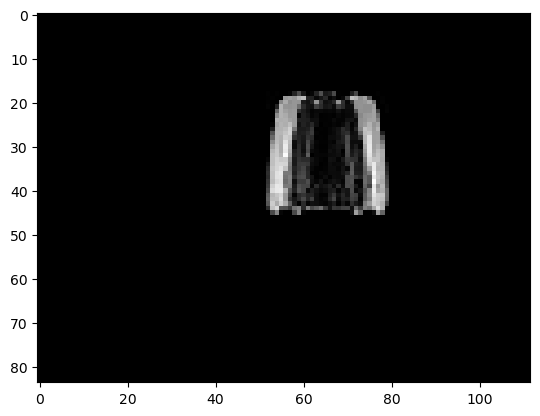

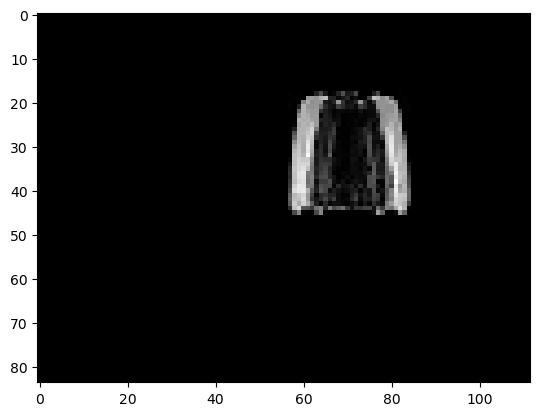

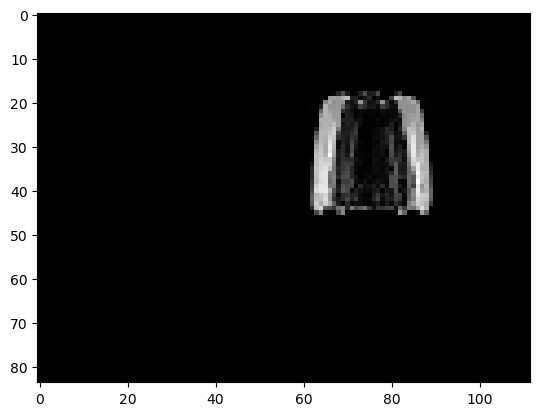

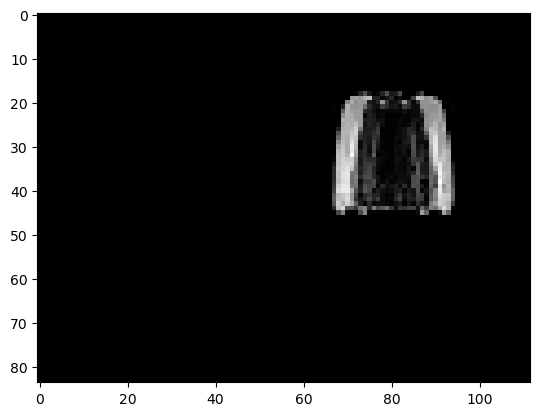

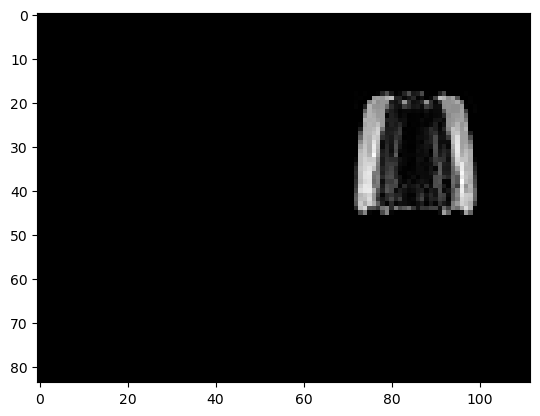

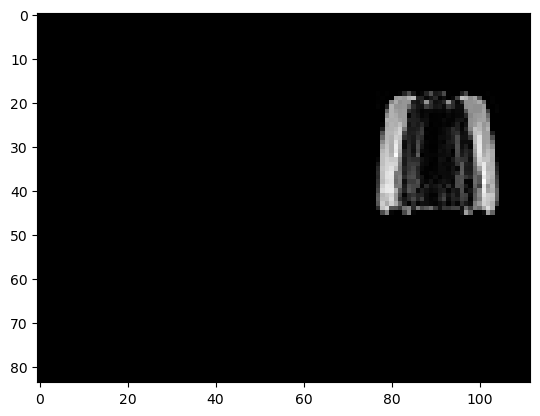

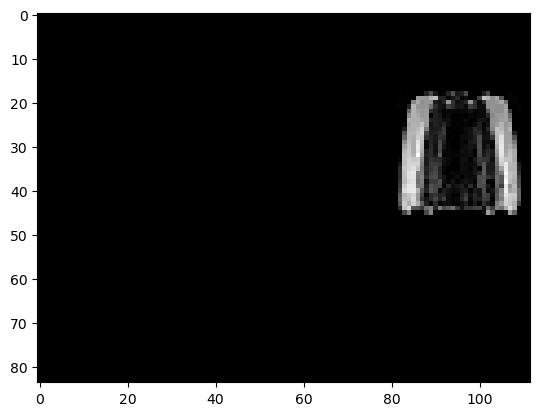

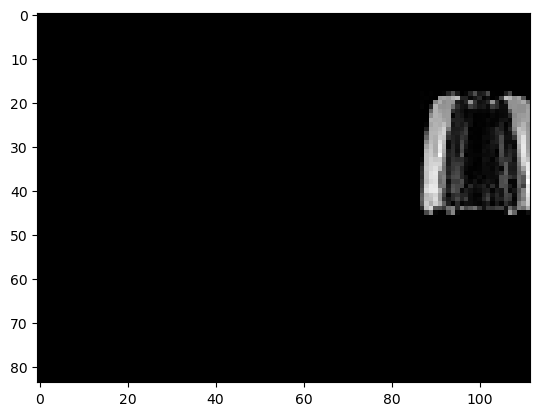

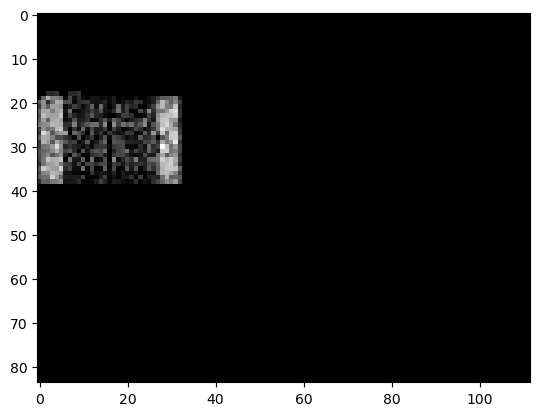

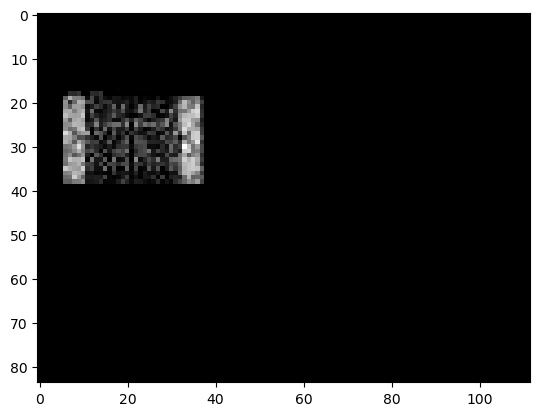

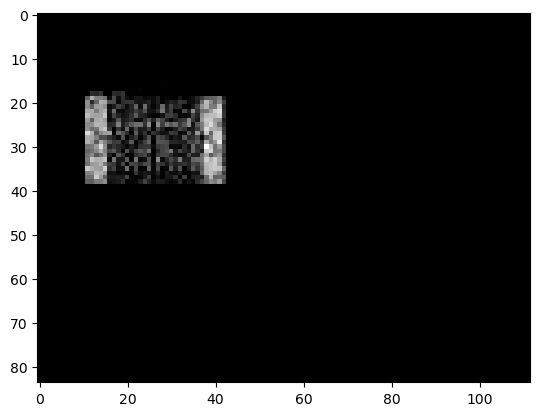

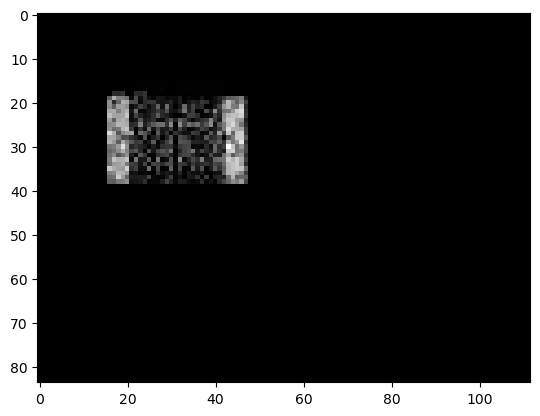

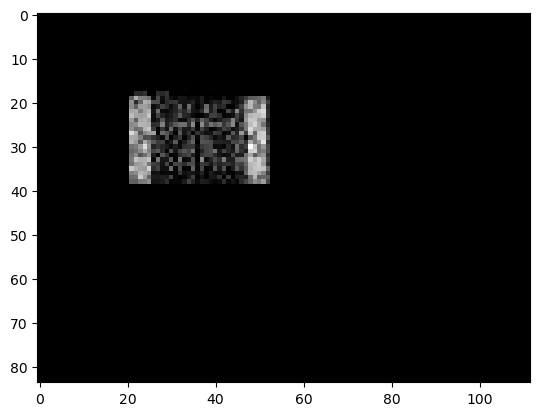

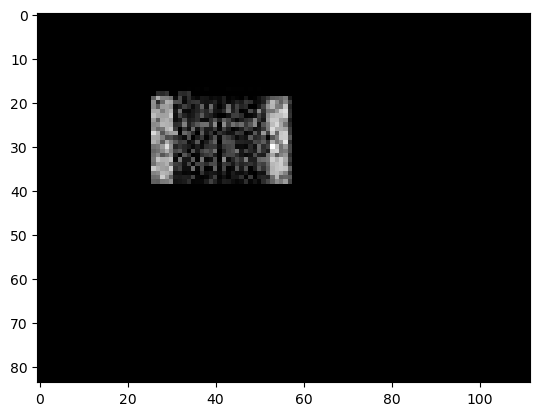

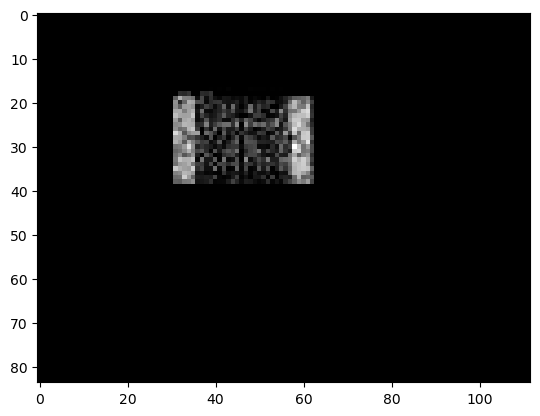

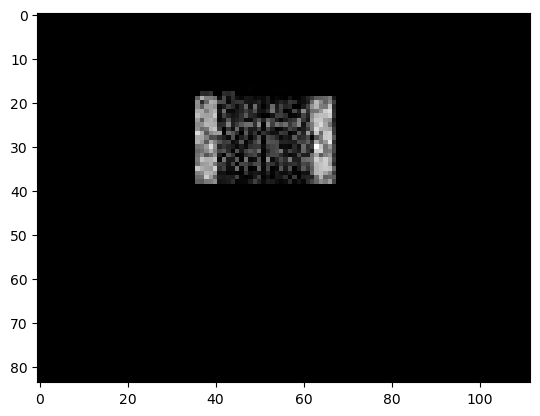

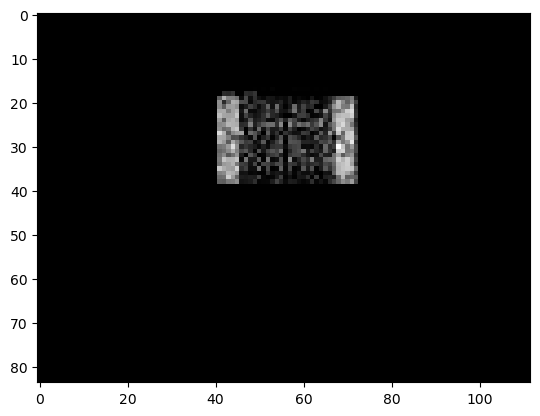

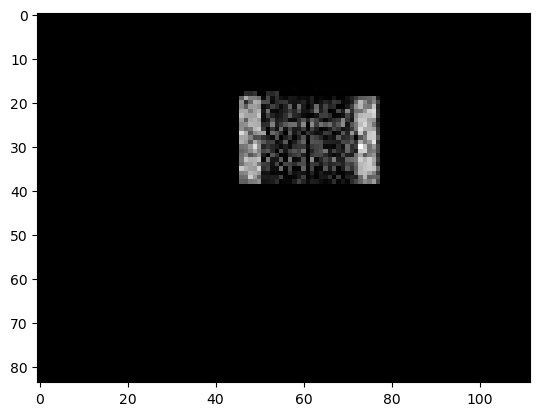

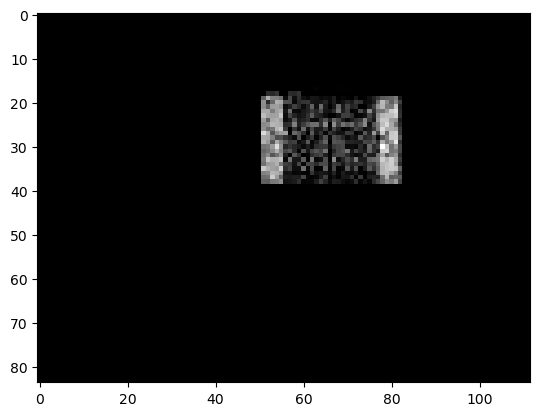

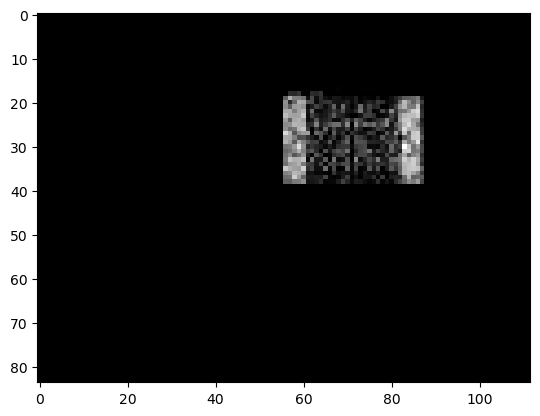

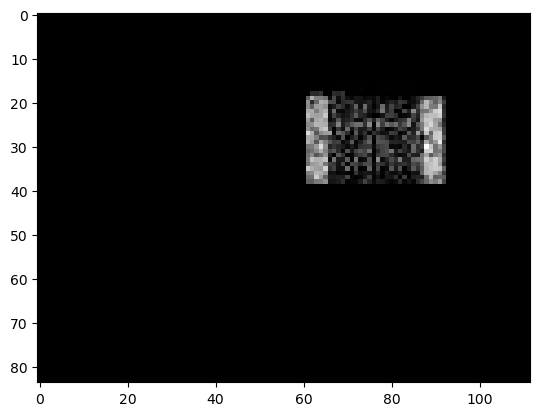

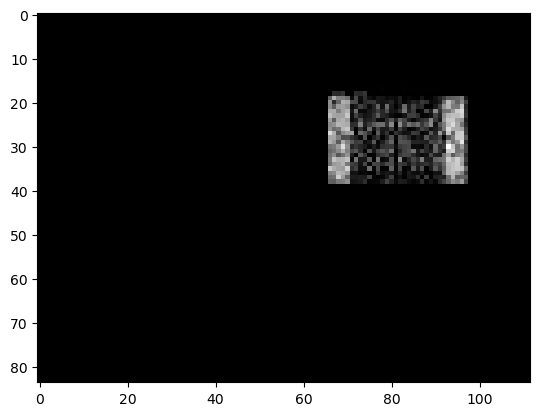

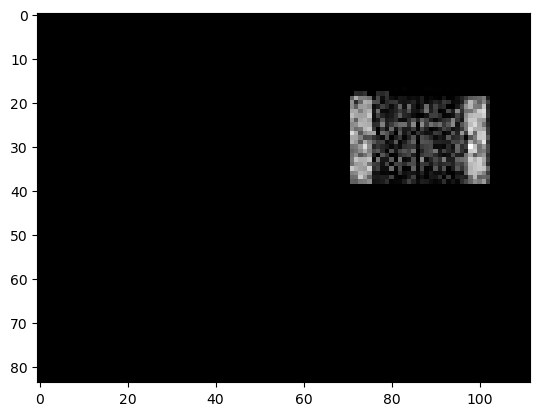

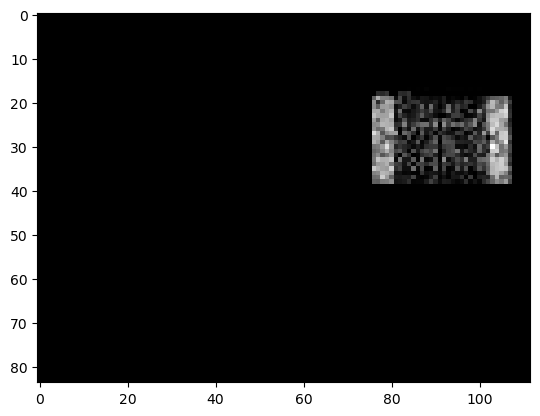

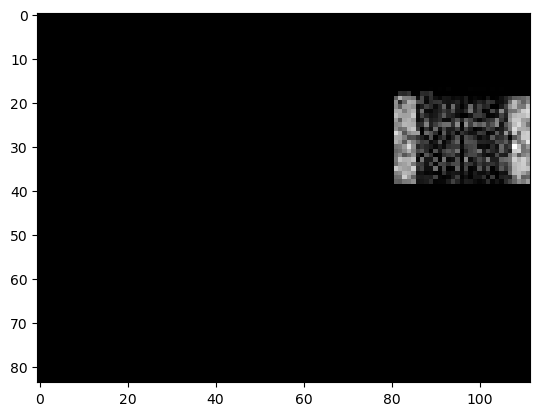

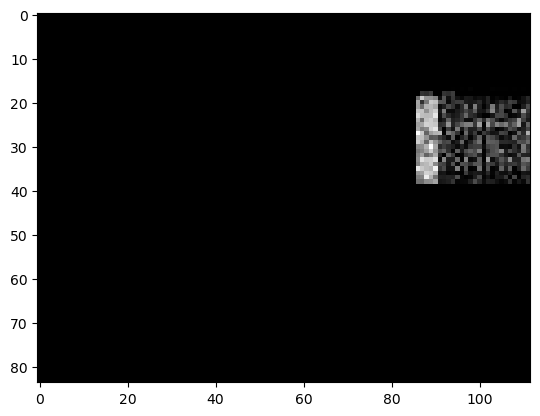

In [45]:
# view image
for i in range(len(test)):
    plt.imshow(test[i], cmap='gray')
    pause(0.01)

In [ ]:
# from torch import is_tensor

# normalization
aug_sample = training_data.data[rand]/255.

# expand and clean
print(aug_sample.size())
aug_sample = aug_sample.repeat(3, 4)
aug_sample[:, 28:] = 0
aug_sample[28:, :] = 0

# print info
print(is_tensor(aug_sample))
print(aug_sample.size())
plt.imshow(aug_sample, cmap='gray')